In [1]:
import numpy as np
import scipy  
import pandas as pd
import pyspark
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SQLContext, DataFrame, SparkSession, functions
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, Word2Vec
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC, RandomForestClassifier, MultilayerPerceptronClassifier,GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [2]:
spark=SparkSession.builder.appName('NewsClassification').config("spark.driver.memory", "16g").getOrCreate()
data = spark.read.csv('file:///home/lalala/hadoop/train.csv', header=True)
train, test = data.randomSplit([0.9,0.1],seed=2022)

/usr/local/hadoop/spark-3.2.0-bin-hadoop3.2/python/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


# title

In [3]:
title_tokenizer = Tokenizer(inputCol="title", outputCol="words")
title_w2v = Word2Vec(vectorSize=20, minCount=1, inputCol="words", outputCol="w2v")

x_train_title = train.select(["lable","title"])
x_test_title = test.select(["lable","title"])

# # 标题
#tokenizer
x_train_title_token = title_tokenizer.transform(x_train_title)
x_test_title_token = title_tokenizer.transform(x_test_title)
#tf   
title_w2v_model = title_w2v.fit(x_train_title_token)
x_train_title_w2v = title_w2v_model.transform(x_train_title_token)
x_test_title_w2v = title_w2v_model.transform(x_test_title_token)

In [4]:
x_train_title_w2v_1 = x_train_title_w2v.drop("title").drop("words")
pandasdf = x_train_title_w2v_1.toPandas()
# x_train_title_w2v.filter(x_train_title_w2v.lable==0 | x_train_title_w2v.lable==1)
neg = pandasdf[pandasdf["lable"]=="0"]
pos = pandasdf[pandasdf["lable"]=="1"]
train_new = pd.concat([neg,pos]).reset_index(drop=True)
train_new["lable"].astype(int)
values = train_new.values.tolist()
columns = train_new.columns.tolist()
train_new_sprak = spark.createDataFrame(values,columns)
train_new_sprak2 = train_new_sprak.withColumn("lable_int",train_new_sprak['lable'].cast('int')).drop('lable')

In [5]:
x_test_title_w2v_1 = x_test_title_w2v.drop("title").drop("words")
pandasdf = x_test_title_w2v_1.toPandas()
# x_train_title_w2v.filter(x_train_title_w2v.lable==0 | x_train_title_w2v.lable==1)
neg = pandasdf[pandasdf["lable"]=="0"]
pos = pandasdf[pandasdf["lable"]=="1"]
test_new = pd.concat([neg,pos]).reset_index(drop=True)
test_new["lable"].astype(int)
values = test_new.values.tolist()
columns = test_new.columns.tolist()
test_new_sprak = spark.createDataFrame(values,columns)
test_new_sprak2 = test_new_sprak.withColumn("lable_int",test_new_sprak['lable'].cast('int')).drop('lable')

# text

In [6]:
x_train_text = train.select(["lable","text"])
df2 = x_train_text.toPandas()
text_list_train = list(map(lambda x: str(x).split(" "), list(df2["text"].astype(str))))
df2["words"] = text_list_train
values = df2.values.tolist()
columns = df2.columns.tolist()
x_train_text_token = spark.createDataFrame(values,columns)

In [7]:
x_test_text = test.select(["lable","text"])
df2 = x_test_text.toPandas()
text_list_test = list(map(lambda x: str(x).split(" "), list(df2["text"].astype(str))))
df2["words"] = text_list_test
values = df2.values.tolist()
columns = df2.columns.tolist()
x_test_text_token = spark.createDataFrame(values,columns)

In [8]:
text_w2v = Word2Vec(vectorSize=20, minCount=1, inputCol="words", outputCol="w2v")
text_w2v_model = text_w2v.fit(x_train_text_token)
x_train_text_w2v = text_w2v_model.transform(x_train_text_token)
x_test_text_w2v = text_w2v_model.transform(x_test_text_token)
x_train_text_w2v_1=x_train_text_w2v.drop("text").drop("words")
x_test_text_w2v_1=x_test_text_w2v.drop("text").drop("words")
x_train_text_w2v_2 = x_train_text_w2v_1.withColumn("lable_int",x_train_text_w2v_1['lable'].cast('int')).drop('lable')
x_test_text_w2v_2 = x_test_text_w2v_1.withColumn("lable_int",x_test_text_w2v_1['lable'].cast('int')).drop('lable')

# subject

In [ ]:
# subject no use
x_train_subject = train.select(["lable","subject"])
x_test_subject = test.select(["lable","subject"])

# concat title w2v with text w2v

In [9]:
#train title+text
title_train_df = train_new_sprak2.toPandas()
text_train_df = x_train_text_w2v_2.toPandas()
concat_train = []
for i,j in zip(title_train_df["w2v"],text_train_df["w2v"]):
    concat_train.append(DenseVector(list(i)+list(j)))
pddf_train = title_train_df.copy().drop("w2v",axis=1)
pddf_train["w2v"]=concat_train
values = pddf_train.values.tolist()
columns = pddf_train.columns.tolist()
spdf_train = spark.createDataFrame(values,columns)

In [10]:
#train title+text
title_test_df = test_new_sprak2.toPandas()
text_test_df = x_test_text_w2v_2.toPandas()
concat_test = []
for i,j in zip(title_test_df["w2v"],text_test_df["w2v"]):
    concat_test.append(DenseVector(list(i)+list(j)))
pddf_test = title_test_df.copy().drop("w2v",axis=1)
pddf_test["w2v"]=concat_test
values = pddf_test.values.tolist()
columns = pddf_test.columns.tolist()
spdf_test = spark.createDataFrame(values,columns)

# classifier model and evaluate

In [11]:
lr = LogisticRegression(featuresCol="w2v",labelCol="lable_int")
lr_model = lr.fit(spdf_train)
result = lr_model.transform(spdf_test)
p = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='weightedPrecision').evaluate(result)
r = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='weightedRecall').evaluate(result)
f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='f1').evaluate(result)
accuracy = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='accuracy').evaluate(result)
roc_auc = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol="lable_int", metricName='areaUnderROC').evaluate(result)
pr_auc = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol="lable_int", metricName='areaUnderPR').evaluate(result)
print("LR == accuracy-",accuracy,", precision-",p,", recall-",r,", f1 score-", f1,", roc-auc-",roc_auc,", pr-auc-",pr_auc)

LR == accuracy- 0.9443104582328437 , precision- 0.9446679364375072 , recall- 0.9443104582328437 , f1 score- 0.9442911886620388 , roc-auc- 0.9441690713735463 , pr-auc- 0.9407804253724824


In [12]:
dt = DecisionTreeClassifier(featuresCol="w2v",labelCol="lable_int")
dt_model = dt.fit(spdf_train)
result = dt_model.transform(spdf_test)
p = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='weightedPrecision').evaluate(result)
r = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='weightedRecall').evaluate(result)
f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='f1').evaluate(result)
accuracy = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='accuracy').evaluate(result)
roc_auc = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol="lable_int", metricName='areaUnderROC').evaluate(result)
pr_auc = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol="lable_int", metricName='areaUnderPR').evaluate(result)
print("DecisionTree == accuracy-",accuracy,", precision-",p,", recall-",r,", f1 score-", f1,", roc-auc-",roc_auc,", pr-auc-",pr_auc)

DecisionTree == accuracy- 0.8875246656434992 , precision- 0.8884267326854189 , recall- 0.8875246656434992 , f1 score- 0.8874292436367341 , roc-auc- 0.887281071678149 , pr-auc- 0.8782940823653221


In [13]:
rf = RandomForestClassifier(featuresCol="w2v",labelCol="lable_int")
rf_model = rf.fit(spdf_train)
result = rf_model.transform(spdf_test)
p = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='weightedPrecision').evaluate(result)
r = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='weightedRecall').evaluate(result)
f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='f1').evaluate(result)
accuracy = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='accuracy').evaluate(result)
roc_auc = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol="lable_int", metricName='areaUnderROC').evaluate(result)
pr_auc = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol="lable_int", metricName='areaUnderPR').evaluate(result)
print("RF == accuracy-",accuracy,", precision-",p,", recall-",r,", f1 score-", f1,", roc-auc-",roc_auc,", pr-auc-",pr_auc)

RF == accuracy- 0.9160271870203902 , precision- 0.9160268654865381 , recall- 0.9160271870203902 , f1 score- 0.9160266299092776 , roc-auc- 0.9160135209716208 , pr-auc- 0.897817471208022


In [14]:
svc = LinearSVC(featuresCol="w2v",labelCol="lable_int")
svc_model = svc.fit(spdf_train)
result = svc_model.transform(spdf_test)
p = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='weightedPrecision').evaluate(result)
r = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='weightedRecall').evaluate(result)
f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='f1').evaluate(result)
accuracy = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='accuracy').evaluate(result)
roc_auc = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol="lable_int", metricName='areaUnderROC').evaluate(result)
pr_auc = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol="lable_int", metricName='areaUnderPR').evaluate(result)
print("LinerSVC == accuracy-",accuracy,", precision-",p,", recall-",r,", f1 score-", f1,", roc-auc-",roc_auc,", pr-auc-",pr_auc)

LinerSVC == accuracy- 0.9427757070817803 , precision- 0.943058467318349 , recall- 0.9427757070817804 , f1 score- 0.9427591444353575 , roc-auc- 0.9426486543448755 , pr-auc- 0.9378428422426994


In [15]:
mlp = MultilayerPerceptronClassifier(featuresCol="w2v",labelCol="lable_int",layers=[40,16,2])
mlp_model = mlp.fit(spdf_train)
result = mlp_model.transform(spdf_test)
p = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='weightedPrecision').evaluate(result)
r = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='weightedRecall').evaluate(result)
f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='f1').evaluate(result)
accuracy = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="lable_int", metricName='accuracy').evaluate(result)
roc_auc = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol="lable_int", metricName='areaUnderROC').evaluate(result)
pr_auc = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol="lable_int", metricName='areaUnderPR').evaluate(result)
print("MLP == accuracy-",accuracy,", precision-",p,", recall-",r,", f1 score-", f1,", roc-auc-",roc_auc,", pr-auc-",pr_auc)

MLP == accuracy- 0.9484762113571585 , precision- 0.9488496075542439 , recall- 0.9484762113571585 , f1 score- 0.9484579468559541 , roc-auc- 0.9483331275727287 , pr-auc- 0.9460911164663939


# TSNE

In [16]:
import ast
from sklearn.manifold import TSNE

In [17]:
vec_train = []
vec_test = []
for i in pddf_train["w2v"]:
    vec_train.append(ast.literal_eval(i))
for i in pddf_test["w2v"]:
    vec_test.append(ast.literal_eval(i)) 

<AxesSubplot:xlabel='x_dim', ylabel='y_dim'>

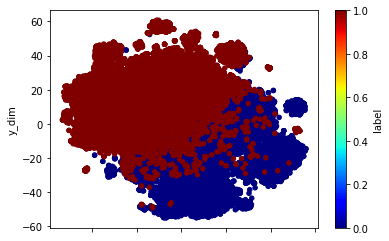

In [18]:
#训练集
ts = TSNE(n_components=2)
ts.fit_transform(vec_train)
vec_2 = pd.DataFrame(ts.embedding_)
df_vec_2 = pd.concat([pddf_train["lable_int"], vec_2], axis=1)
df_vec_2.columns = ['label','x_dim','y_dim']
df_vec_2.plot.scatter("x_dim", "y_dim", c="label", colormap='jet')

<AxesSubplot:xlabel='x_dim', ylabel='y_dim'>

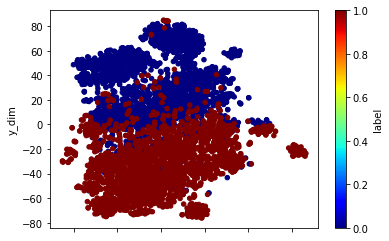

In [19]:
#测试集
ts = TSNE(n_components=2)
ts.fit_transform(vec_test)
vec_2 = pd.DataFrame(ts.embedding_)
df_vec_2 = pd.concat([pddf_test["lable_int"], vec_2], axis=1)
df_vec_2.columns = ['label','x_dim','y_dim']
df_vec_2.plot.scatter("x_dim", "y_dim", c="label", colormap='jet')